In [2]:
from wmf import wmf 
import numpy as np
import pylab as pl
import pandas as pnd
import pickle
import datetime
from datetime import timedelta
%matplotlib inline

### Trazado y guardado de cosas básicas de la cuenca

In [3]:
#Trazar cuenca para poder usar SimuBasin.
DEM=wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/dem_amva12.tif',True)
DIR=wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/dir12.tif',True)
wmf.cu.nodata=-9999.0; wmf.cu.dxp=12.7
DIR[DIR<=0]=wmf.cu.nodata.astype(int)
DIR=wmf.cu.dir_reclass_rwatershed(DIR,wmf.cu.ncols,wmf.cu.nrows)

In [4]:
#Corriente que pase cerca- punto aguas arriba del usado para trazar la cuenca.
St = wmf.Stream(-75.62664, 6.09253,DEM=DEM,DIR=DIR,name ='la_corrala_259')

In [5]:
St.Save_Stream2Map('/media/nicolas/Home/nicolas/01_SIATA/vector/vector_sora/alarmas/corr_lacorrala_259.shp')

In [6]:
# Trazado de la cuenca - punto de la estacion
cu = wmf.SimuBasin(-75.62674, 6.09263, DEM, DIR, name='la_corrala_259',
    dt = 300, stream = St)

/usr/local/lib/python2.7/dist-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [7]:
#Guardado del shp de la cuenca y la red
cu.Save_Basin2Map('/media/nicolas/Home/nicolas/01_SIATA/vector/vector_sora/alarmas/Cuenca_LaCorrala259.shp')
cu.Save_Net2Map('/media/nicolas/Home/nicolas/01_SIATA/vector/vector_sora/alarmas/red_lacorrala_259.shp', NumTramo=True, umbral=300)

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


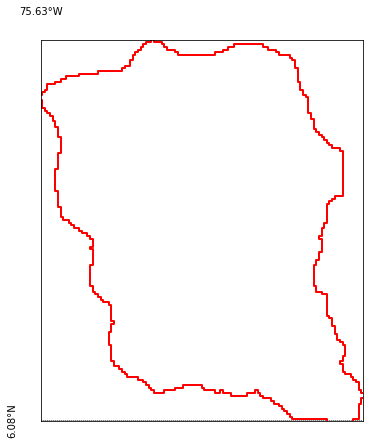

(<mpl_toolkits.basemap.Basemap at 0x7f400acb1310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f400ac391d0>)

In [8]:
cu.Plot_basin()

In [9]:
#Obtener parámetros geomorfológicos
cu.GetGeo_Cell_Basics()
#como es un modelo por celdas el ancho del canal es igual al largo de la celda.
cu.set_Geomorphology(stream_width=cu.CellLong)

### Mapas

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


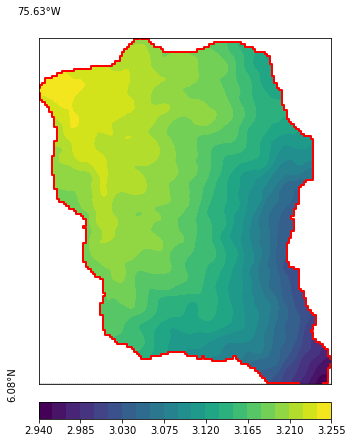

(<mpl_toolkits.basemap.Basemap at 0x7f400aa72cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f400ac67290>)

In [10]:
# Evaporación en la cuenca estimada por Turc (?)
Evp=4.658*np.exp(-0.0002*cu.CellHeight)
cu.Plot_basin(Evp,lines_spaces=0.025)

In [11]:
#Lectura de la profunidad de raiz
Z,p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/Prof_raiz_cm.tif')
Z = cu.Transform_Map2Basin(Z,p)
Z[Z == -9999] = 40.0
Z[Z==0]=40

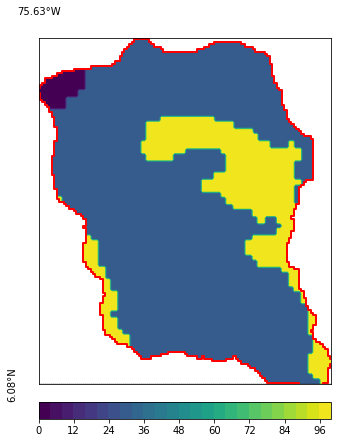

(<mpl_toolkits.basemap.Basemap at 0x7f3ff97c4e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff9835510>)

In [12]:
cu.Plot_basin(Z,lines_spaces=0.5)

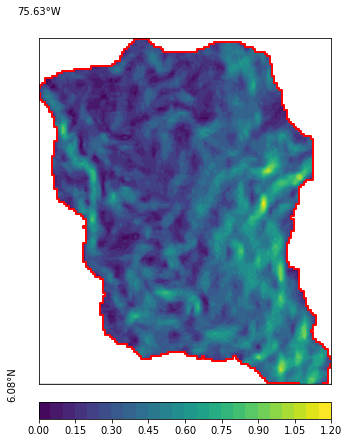

(<mpl_toolkits.basemap.Basemap at 0x7f3ff95a6750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff9680e10>)

In [13]:
cu.Plot_basin(cu.CellSlope)

In [14]:
#Profundidad por geomorfologia
Zg = np.zeros(cu.ncells)
Zg[cu.CellSlope<0.22]=1.0
Zg[(cu.CellSlope>=0.22)&(cu.CellSlope<0.45)]=0.6
Zg[(cu.CellSlope>=0.45)&(cu.CellSlope<0.7)]=0.3
Zg[cu.CellSlope>=0.7] = 0.2

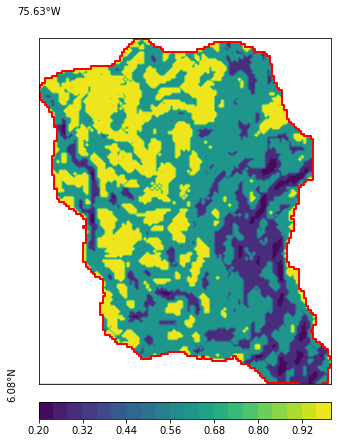

(<mpl_toolkits.basemap.Basemap at 0x7f3ff93874d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff945cc90>)

In [15]:
cu.Plot_basin(Zg,lines_spaces=0.05)

Contenido volumétrico de agua

In [16]:
Tetas = {}
for i in ['Teta_pmp','Teta_cp','Teta_sat']:
    te,p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/'+i+'.tif')
    te = cu.Transform_Map2Basin(te,p)
    te[te == -9999] = te[te>0].mean()
    te[te == 0] = te[te>0].mean()
    Tetas.update({i:te})

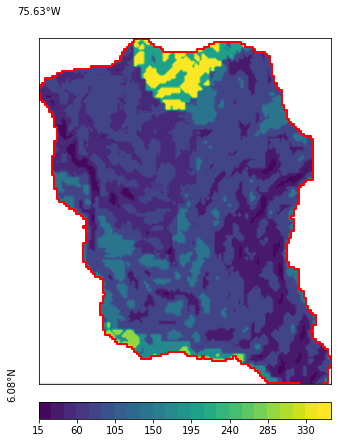

(<mpl_toolkits.basemap.Basemap at 0x7f3ff90a3c90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff91995d0>)

In [17]:
Hu  = Zg * (Tetas['Teta_cp']-Tetas['Teta_pmp'])*10
Hg  = Zg * (Tetas['Teta_sat']-Tetas['Teta_cp'])*10
cu.Plot_basin(Hg,lines_spaces=0.08)

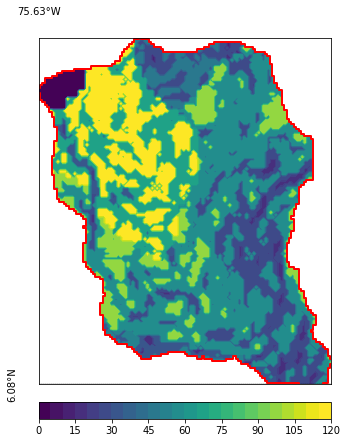

(<mpl_toolkits.basemap.Basemap at 0x7f3ff8ec0ed0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff8f1fc50>)

In [18]:
Hu[Z == 2] = 2
cu.Plot_basin(Hu,lines_spaces=0.05)

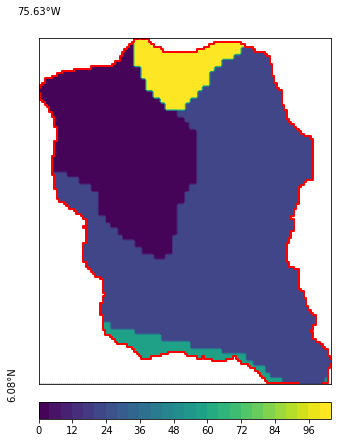

(<mpl_toolkits.basemap.Basemap at 0x7f3ff8be2c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff8d383d0>)

In [19]:
Ks, p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/'+'Ks_mm_h.tif')
Ks = cu.Transform_Map2Basin(Ks,p)
Ks[Ks == -9999] = Ks[Ks>0].mean()
Ks[Ks == 0] = Ks[Ks>0].mean()
Kp = np.copy(Ks) / 100.0
cu.Plot_basin(Ks,lines_spaces=0.08)

In [20]:
ksh=((Ks/3600000.0)*cu.CellSlope*(30.0**2.0))/(3*(Hg*0.9/1000.0)**2)

In [21]:
kcopy = np.zeros(ksh.shape)
kcopy[(ksh>0) & (ksh<0.05)] = 0.025
kcopy[(ksh>=0.1) & (ksh<0.1)] = 0.05
kcopy[(ksh>=0.1) & (ksh<0.25)] = 0.15
kcopy[(ksh>=0.25) & (ksh<0.5)] = 0.35
kcopy[(ksh>=0.5) & (ksh<0.75)] = 0.6
kcopy[(ksh>=0.5) & (ksh<1.0)] = 0.75
kcopy[(ksh>=1.0) & (ksh<2.0)] = 1.5
kcopy[(ksh>=2.0) & (ksh<3.0)] = 2.0
kcopy[(ksh>=3.0)] = 3.0

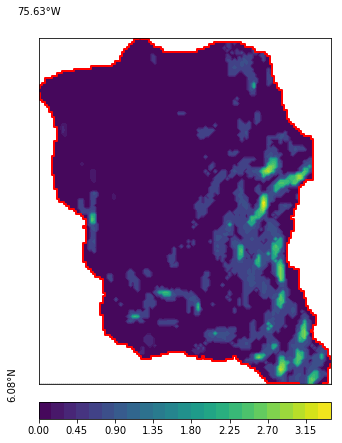

(<mpl_toolkits.basemap.Basemap at 0x7f3ff8a17c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff8cbb6d0>)

In [22]:
cu.Plot_basin(ksh,lines_spaces=0.05)

La velocidad en laderas puede ser descrita de dos formas:

- Mediante una ecuación lineal, en la cual no se tiene en cuenta el almacenamiento, en este caso se puede asumir que:
   * $v_{lad} = C_{oef} S_{0}^{1/2}$
- Mediante una ecuación no lineal, en este caso se puede asumir que la velocidad depende del almacenamiento y de características regionales en la cuenca asociadas a los surcos, de acuerdo a Vélez (2001) esto se puede escribir:
   * $v_{lad} = \frac{\xi}{n} A ^{(2/3)e_1} S_{0}^{1/2}$  En este caso $\xi$ y $e_1$ van a variar de acuerdo al tipo de surcos que se asuman, en este aspecto diferentes autores proponen diferentes aproximaciones:
      * $\xi$ puede tomar valores de: 0.5, 0.44, 0.38
      * $e_{1}$ puede tomar valores: 0.64, 0.53, 0.315
      
#### Vel. Laderas lineal

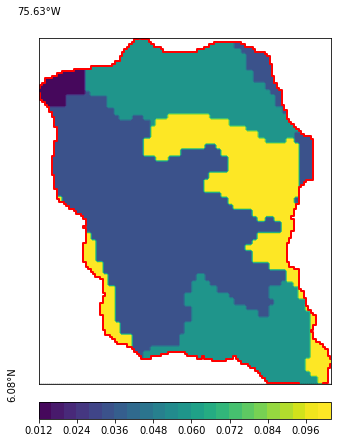

(<mpl_toolkits.basemap.Basemap at 0x7f3ff8896610>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff897df90>)

In [23]:
man,p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/n_man.asc')
man = cu.Transform_Map2Basin(man,p)
cu.Plot_basin(man,lines_spaces=0.05)

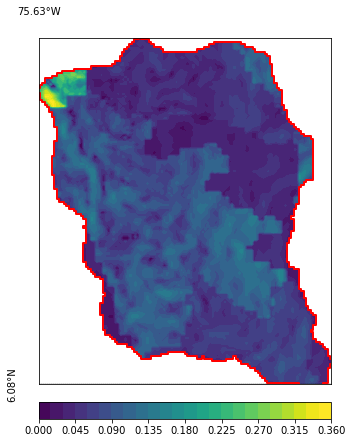

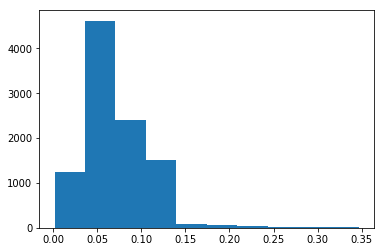

In [24]:
v_lad = (1.41/(man*240))*cu.CellSlope**(1.0/2.0)
cu.Plot_basin(v_lad,lines_spaces=0.05)
pos = np.random.choice(cu.ncells,10000)
h = pl.hist(v_lad[pos])

#### OCG

In [25]:
area = cu.CellAcum * (30**2)/1e6 #Tamaño de celda al cuadrado
CoefOCG,ExpOCG = wmf.OCG_param(pend = cu.CellSlope, area = area)

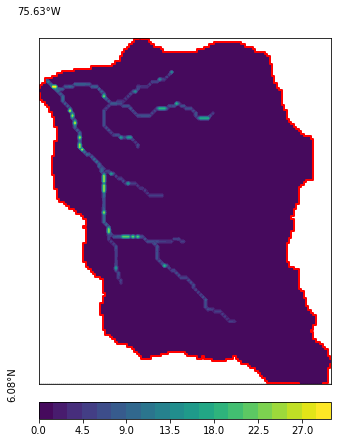

(<mpl_toolkits.basemap.Basemap at 0x7f3ff83c8590>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff8444d90>)

In [26]:
cu.Plot_basin(CoefOCG*cu.CellCauce,lines_spaces=0.05)

### Deslizamientos

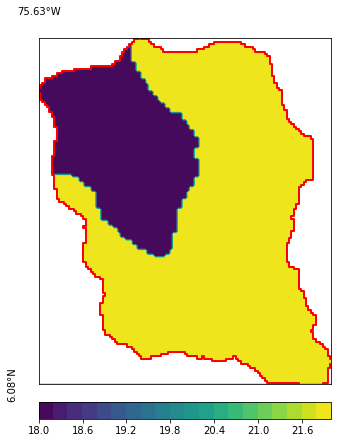

In [27]:
#Lectura y transformacion a formato cuenca
Map, p = wmf.read_map_raster('/media/nicolas/Home/nicolas/02_SIATA_Desliz/raster/AnguloFric.asc')
Map = cu.Transform_Map2Basin(Map, p )
#Quita no data y valores nulos
Map[Map == -9999] = np.nan
Map[np.isnan(Map)] = np.nanmean(Map)
Map[Map == 0] = np.nanmean(Map)
#lo mete en el modelo 
cu.set_Slides(Map, 'FrictionAngle')
#Plot Para ver como queda 
m = cu.Plot_basin(Map, lines_spaces=0.1)

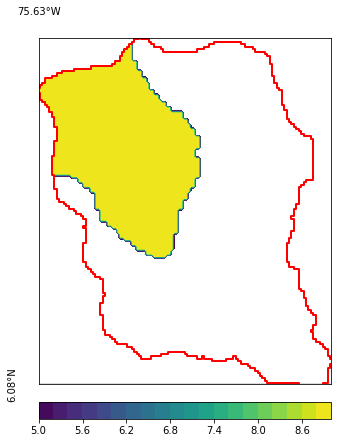

(<mpl_toolkits.basemap.Basemap at 0x7f3ff8b8cd90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ff85bd790>)

In [28]:
#Lectura y transformacion a formato cuenca
Map, p = wmf.read_map_raster('/media/nicolas/Home/nicolas/02_SIATA_Desliz/raster/Cohesion.asc')
Map = cu.Transform_Map2Basin(Map, p )
#lo mete en el modelo 
Map[Map == -9999] = 4
cu.set_Slides(Map, 'Cohesion')
#Plot Para ver como queda 
cu.Plot_basin(Map, lines_spaces=0.1)

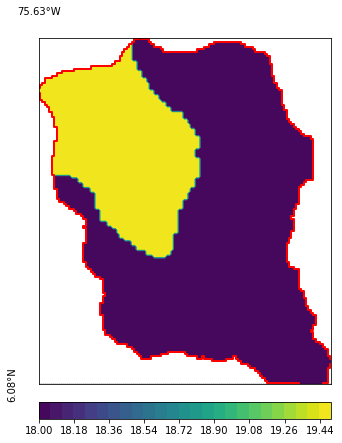

In [29]:
#Lectura y transformacion a formato cuenca
Map, p = wmf.read_map_raster('/media/nicolas/Home/nicolas/02_SIATA_Desliz/raster/pesoEsp.asc')
Map = cu.Transform_Map2Basin(Map, p )
#Quita no data y valores nulos
Map[Map == -9999] = np.nan
Map[np.isnan(Map)] = np.nanmean(Map)
Map[Map == 0] = np.nanmean(Map)
#lo mete en el modelo 
cu.set_Slides(Map, 'GammaSoil')
#Plot Para ver como queda 
m = cu.Plot_basin(Map, lines_spaces=0.1)

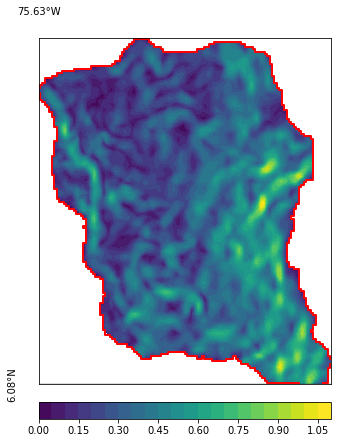

In [30]:
slope = wmf.cu.basin_arc_slope(cu.structure, cu.DEM, cu.ncells, wmf.cu.ncols, wmf.cu.nrows)
#Valores contantes debido a que no hay mapas 
cu.set_Slides(slope,'Slope')
cu.set_Slides(0.5,'FS')
m = cu.Plot_basin(slope, lines_spaces=0.1)

### Parámetros que no cambian

In [31]:
#Almacenamiento capilar y gravitacional 
cu.set_PhysicVariables('capilar',Hu,0)
cu.set_PhysicVariables('gravit',Hg,1)
#como hay tanque gravitacional, se establece que si hay retorno 
wmf.models.retorno = 1

In [32]:
# Evaporacion, infiltracion, percolacion y perdidas
cu.set_PhysicVariables('v_coef',Evp,0)
#Infiltracion, se hace impermeable la ciudad, se pasa a [mm/seg]
KsForMap = np.copy(Ks)/3600.0
KsForMap.min()
KsForMap[Z==2] = 0.0001
cu.set_PhysicVariables('v_coef',KsForMap,1)
#Percolacion se pasa a [mm/seg]
cu.set_PhysicVariables('v_coef',Kp/3600.0,2)
#Se asume perdidas del sistema iguales a cero 
cu.set_PhysicVariables('v_coef',0,3)

### Nodos

cu.GetGeo_Cell_Basics()

cauce,nodos,n_nodos = wmf.cu.basin_subbasin_nod(
    cu.structure,
    cu.CellAcum,
    300,
    cu.ncells)
pos = np.where(nodos<>0)[0]
x,y = wmf.cu.basin_coordxy(cu.structure,cu.ncells)

idsOrd,xy = cu.set_Control(np.vstack([x[pos],y[pos]]),nodos[pos])

## Guardar .nc no lineal en subsup.

In [33]:
cu.set_Speed_type([2,2,1]) #set lineal todo

In [34]:
#Coloca todas las velocidades en lineal 
cu.set_Speed_type(np.array([2,2,1]))
# Coeficientes de velocidad horizontal 
cu.set_PhysicVariables('h_coef',v_lad,0)
cu.set_PhysicVariables('h_exp',1,0) # Linealiza la ladera de nuevo 
#El flujo sub-superficial se hace no lineal 
cu.set_PhysicVariables('h_coef',ksh,1)
cu.set_PhysicVariables('h_exp',2.0,1)
# Guarda la version lineal 
cu.Save_SimuBasin('/media/nicolas/Home/nicolas/01_SIATA/nc_cuencas/nc_soraya/alarmas/cuenca_lacorrala259_v03.nc',SimSlides=True,
    ruta_dem = '/media/nicolas/Home/nicolas/01_SIATA/raster/dem_amva12.tif',
    ruta_dir = '/media/nicolas/Home/nicolas/01_SIATA/raster/dir12.tif')